2024-05-15 16:38:50.412138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


epoch 1/200
train loss: 2.3551, train accuracy: 11.70%
test loss: 2.3786, test accuracy: 15.00%
------------------------------
epoch 2/200
train loss: 2.3005, train accuracy: 11.70%
test loss: 2.2893, test accuracy: 15.00%
------------------------------
epoch 3/200
train loss: 2.2957, train accuracy: 10.00%
test loss: 2.2811, test accuracy: 11.00%
------------------------------
epoch 4/200
train loss: 2.2922, train accuracy: 11.70%
test loss: 2.2744, test accuracy: 14.00%
------------------------------
epoch 5/200
train loss: 2.2884, train accuracy: 11.60%
test loss: 2.2740, test accuracy: 14.00%
------------------------------
epoch 6/200
train loss: 2.2833, train accuracy: 11.20%
test loss: 2.2661, test accuracy: 12.00%
------------------------------
epoch 7/200
train loss: 2.2762, train accuracy: 11.70%
test loss: 2.2610, test accuracy: 15.00%
------------------------------
epoch 8/200
train loss: 2.2657, train accuracy: 11.70%
test loss: 2.2546, test accuracy: 15.00%
---------------

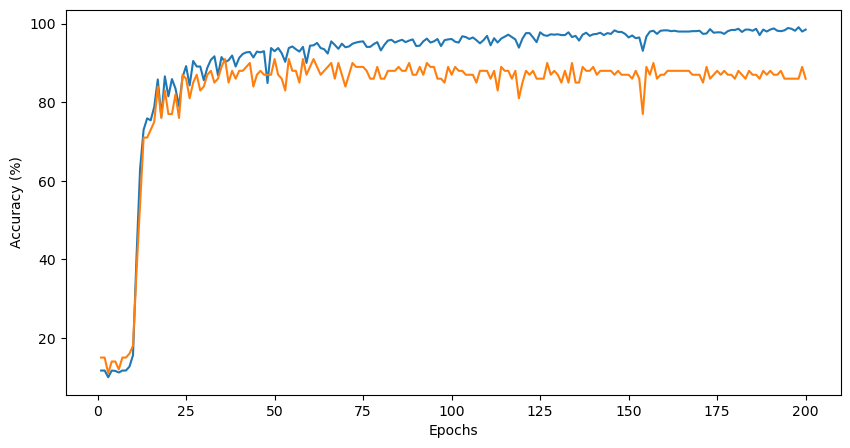

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0


def sigmoid(x):
    x = np.clip(x, -500, 500) 
    return 1 / (1 + np.exp(-x))

def dsigmoid(y):
    return sigmoid(y) * (1 - sigmoid(y))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / exp_x.sum(axis=-1, keepdims=True)

def loss(predictions, targets):
    return -np.sum(targets * np.log(predictions + 1e-9)) / targets.shape[0]

def one_hot_encoding(y, num_classes=10):
    hot_y = np.zeros((len(y), num_classes))
    for i in range(len(hot_y)):
        hot_y[i, int(y[i])] = 1
    return hot_y

def conv2d(input, filters, b1):
    out = np.zeros((input.shape[0], 2, 26, 26))

    for i in range(26):
        for j in range(26):
            region = input[:, i:i+3, j:j+3]
            out[:, :, i, j] = np.tensordot(region, filters, axes=([1, 2], [1, 2])) + b1
    return out

def avg_pool(input):
    averaged = input.reshape(input.shape[0], 2, 13, 2, 13, 2).mean(axis=(3, 5))
    return averaged

def flatten(input):
    batch_size = input.shape[0]
    return input.reshape(batch_size, -1)

def onebyone(input, w_onebyone, b2):
    return np.dot(input, w_onebyone) + b2


def d_loss(predictions, targets):
    return predictions - targets

def d_pool_out_to_sigmoid_out(pool_out_shape, d_pool_out):
    batch_size, num_filters, output_height, output_width = pool_out_shape
    d_sigmoid_out = np.zeros((batch_size, num_filters, output_height*2, output_width*2))
    for b in range(batch_size):
        for f in range(num_filters):
            for i in range(output_height):
                for j in range(output_width):
                    d_sigmoid_out[b, f, i*2:(i+1)*2, j*2:(j+1)*2] = d_pool_out[b, f, i, j] / 4.0
    return d_sigmoid_out

def d_sigmoid_out_to_conv_out(sigmoid_out, d_sigmoid_out):
    return d_sigmoid_out * dsigmoid(sigmoid_out)

def d_conv_out_to_filters(x, conv_out_shape, d_conv_out):
    batch_size, _, conv_out_height, conv_out_width = conv_out_shape
    d_filters = np.zeros((2, 3, 3))
    for b in range(batch_size):
        for f in range(2):
            for i in range(conv_out_height):
                for j in range(conv_out_width):
                    d_filters[f] += x[b, i:i + 3, j:j + 3] * d_conv_out[b, f, i, j]
    return d_filters

def d_conv_out_to_b1(d_conv_out):
    return np.sum(d_conv_out, axis=(0, 2, 3))

class cnn:
    def __init__(self):
        self.filters = np.random.randn(2, 3, 3) * 0.1
        self.b1 = np.random.randn(2) * 0.1
        self.w_onebyone = np.random.randn(338, 10) * np.sqrt(2 / (338 + 10))  # xavier initialization
        self.b2 = np.zeros(10)

    def forward(self, x):
        self.x = x
        # print(self.x.shape)
        self.conv_out = conv2d(x, self.filters, self.b1)
        # print(self.conv_out.shape)
        self.sigmoid_out = sigmoid(self.conv_out)
        # print(self.sigmoid_out.shape)
        self.pool_out = avg_pool(self.sigmoid_out)
        # print(self.pool_out.shape)
        self.flatten_out = flatten(self.pool_out)
        # print(self.flatten_out.shape)
        self.out_onebyone = onebyone(self.flatten_out, self.w_onebyone, self.b2)
        # print(self.out_onebyone.shape)
        self.out = softmax(self.out_onebyone)
        # print(self.out.shape)
        return self.out

    def backward(self, predictions, targets):
        d_out = d_loss(predictions, targets)  

        d_w_onebyone = np.dot(self.flatten_out.T, d_out)
        d_b2 = np.sum(d_out, axis=0)
        d_flatten_out = np.dot(d_out, self.w_onebyone.T)

        d_pool_out = d_flatten_out.reshape(self.pool_out.shape)

        d_sigmoid_out = d_pool_out_to_sigmoid_out(self.pool_out.shape, d_pool_out)

        d_conv_out = d_sigmoid_out_to_conv_out(self.conv_out, d_sigmoid_out)

        d_filters = d_conv_out_to_filters(self.x, self.conv_out.shape, d_conv_out)
        d_b1 = d_conv_out_to_b1(d_conv_out)

        return d_filters, d_b1, d_w_onebyone, d_b2

    def update_parameters(self, d_filters, d_b1, d_w_onebyone, d_b2, learning_rate=0.01):
        self.filters -= learning_rate * d_filters
        self.b1 -= learning_rate * d_b1
        self.w_onebyone -= learning_rate * d_w_onebyone
        self.b2 -= learning_rate * d_b2

def accuracy(predictions, targets):
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(targets, axis=1)
    return np.mean(y_pred == y_true) * 100  






def train(cnn, x_train, y_train, x_test, y_test, epochs=20, batch_size=64, learning_rate=0.01, early_stop_patience=10):
    y_train = one_hot_encoding(y_train, num_classes=10)
    y_test = one_hot_encoding(y_test, num_classes=10)
    
    train_accs, test_accs = [], []
    best_test_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        perm = np.random.permutation(len(x_train))
        x_train_shuffled = x_train[perm]
        y_train_shuffled = y_train[perm]

        for start in range(0, len(x_train), batch_size):
            end = start + batch_size
            batch_images = x_train_shuffled[start:end]
            batch_labels = y_train_shuffled[start:end]

            predictions = cnn.forward(batch_images)
            d_filters, d_b1, d_w_onebyone, d_b2 = cnn.backward(predictions, batch_labels)
            cnn.update_parameters(d_filters, d_b1, d_w_onebyone, d_b2, learning_rate)
        
        # train_eval
        train_predictions = cnn.forward(x_train)
        train_loss = loss(train_predictions, y_train)
        train_acc = accuracy(train_predictions, y_train)
        
        # test_eval
        test_predictions = cnn.forward(x_test)
        test_loss = loss(test_predictions, y_test)
        test_acc = accuracy(test_predictions, y_test)
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"epoch {epoch + 1}/{epochs}")
        print(f"train loss: {train_loss:.4f}, train accuracy: {train_acc:.2f}%")
        print(f"test loss: {test_loss:.4f}, test accuracy: {test_acc:.2f}%")
        print("-" * 30)

        # early_stopping
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print("early stopping triggered")
            break
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')

cnn_model7 = cnn()
train(cnn_model7, x_train[:1000], y_train[:1000], x_test[:100], y_test[:100], epochs=200, batch_size=64, learning_rate=0.01, early_stop_patience=200)


epoch 1/50
train loss: 0.3733, train accuracy: 88.38%
test loss: 0.3588, test accuracy: 89.09%
------------------------------
epoch 2/50
train loss: 0.3230, train accuracy: 90.24%
test loss: 0.3080, test accuracy: 90.84%
------------------------------
epoch 3/50
train loss: 0.3275, train accuracy: 89.70%
test loss: 0.3179, test accuracy: 90.21%
------------------------------
epoch 4/50
train loss: 0.3088, train accuracy: 90.73%
test loss: 0.3043, test accuracy: 90.96%
------------------------------
epoch 5/50
train loss: 0.2277, train accuracy: 93.14%
test loss: 0.2181, test accuracy: 93.76%
------------------------------
epoch 6/50
train loss: 0.1839, train accuracy: 94.57%
test loss: 0.1771, test accuracy: 94.85%
------------------------------
epoch 7/50
train loss: 0.1667, train accuracy: 95.13%
test loss: 0.1624, test accuracy: 95.18%
------------------------------
epoch 8/50
train loss: 0.1462, train accuracy: 95.62%
test loss: 0.1403, test accuracy: 95.80%
-----------------------

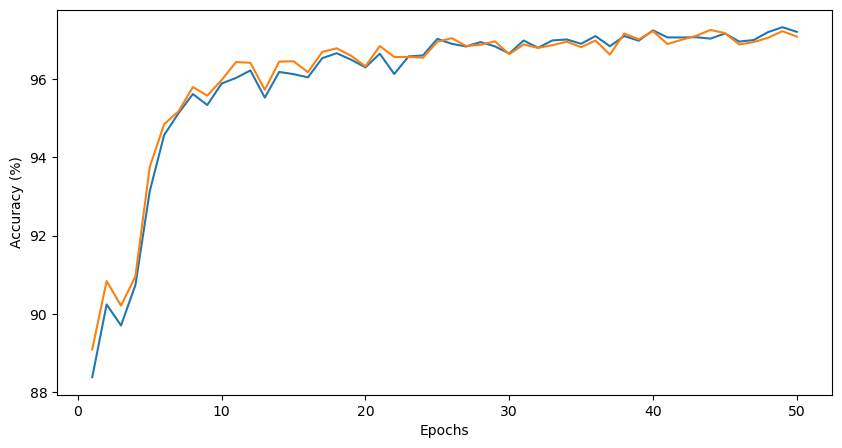

In [2]:
cnn_model8 = cnn()
train(cnn_model8, x_train, y_train, x_test, y_test, epochs=50, batch_size=64, learning_rate=0.01, early_stop_patience=200)
